In [1]:
# Import libraries
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen
from urllib.request import Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Parameters 
n = 3 #the # of article headlines displayed per ticker
tickers = ['AAPL', 'TSLA', 'AMZN']

In [2]:
# Get Data
finviz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}

for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    resp = urlopen(req)    
    html = BeautifulSoup(resp, features="lxml")
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

try:
    for ticker in tickers:
        df = news_tables[ticker]
        df_tr = df.findAll('tr')
    
        print ('\n')
        print ('Recent News Headlines for {}: '.format(ticker))
        
        for i, table_row in enumerate(df_tr):
            a_text = table_row.a.text
            td_text = table_row.td.text
            td_text = td_text.strip()
            print(a_text,'(',td_text,')')
            if i == n-1:
                break
except KeyError:
    pass



Recent News Headlines for AAPL: 
Futures Slash Losses On Possible Biden-Putin Summit Over Ukraine; 5 Stocks That Don't Suck ( Feb-20-22 08:30PM )
Apple Might Have a Wage War on Its Hands ( 01:32PM )
Can Apple Succeed Where Amazon Has Struggled? ( 11:35AM )


Recent News Headlines for TSLA: 
Futures Slash Losses On Possible Biden-Putin Summit Over Ukraine; 5 Stocks That Don't Suck ( Feb-20-22 08:33PM )
Tesla Stock Vs. BYD Stock: Tesla Growing Fast, But EV Rival BYD Sets Huge 2022 Sales Target ( 01:36PM )
Dow Jones Futures: Markets Await Putin's Ukraine Invasion Decision; Five Stocks That Don't Suck ( 08:39AM )


Recent News Headlines for AMZN: 
Is it a Wise Decision to Invest in Amazon.com (AMZN)? ( Feb-20-22 08:20PM )
eBay Earnings Preview: Follow the Cash ( 08:00AM )
3 Unstoppable Nasdaq Front-Runners You Can Still Buy Today ( 07:30AM )


In [3]:
# Iterate through the news
parsed_news = []
for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        text = x.a.get_text() 
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0]
        
        parsed_news.append([ticker, date, time, text])

In [4]:
print(parsed_news[:5])

[['AAPL', 'Feb-20-22', '08:30PM', "Futures Slash Losses On Possible Biden-Putin Summit Over Ukraine; 5 Stocks That Don't Suck"], ['AAPL', 'Feb-20-22', '01:32PM', 'Apple Might Have a Wage War on Its Hands'], ['AAPL', 'Feb-20-22', '11:35AM', 'Can Apple Succeed Where Amazon Has Struggled?'], ['AAPL', 'Feb-20-22', '09:06AM', 'Apple May Have a Wage War On Its Hands'], ['AAPL', 'Feb-20-22', '08:39AM', "Dow Jones Futures: Markets Await Putin's Ukraine Invasion Decision; Five Stocks That Don't Suck"]]


In [5]:
# New words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()
analyzer.lexicon.update(new_words)

columns = ['Ticker', 'Date', 'Time', 'Headline']
news = pd.DataFrame(parsed_news, columns=columns)
scores = news['Headline'].apply(analyzer.polarity_scores).tolist()

df_scores = pd.DataFrame(scores)
news = news.join(df_scores, rsuffix='_right')

In [6]:
print(news.head(5))

  Ticker       Date     Time  \
0   AAPL  Feb-20-22  08:30PM   
1   AAPL  Feb-20-22  01:32PM   
2   AAPL  Feb-20-22  11:35AM   
3   AAPL  Feb-20-22  09:06AM   
4   AAPL  Feb-20-22  08:39AM   

                                            Headline    neg    neu    pos  \
0  Futures Slash Losses On Possible Biden-Putin S...  0.279  0.581  0.140   
1           Apple Might Have a Wage War on Its Hands  0.358  0.642  0.000   
2      Can Apple Succeed Where Amazon Has Struggled?  0.212  0.354  0.434   
3             Apple May Have a Wage War On Its Hands  0.358  0.642  0.000   
4  Dow Jones Futures: Markets Await Putin's Ukrai...  0.000  0.759  0.241   

   compound  
0   -0.3387  
1   -0.5994  
2    0.3612  
3   -0.5994  
4    0.4226  


In [7]:
# View Data 
news['Date'] = pd.to_datetime(news.Date).dt.date

unique_ticker = news['Ticker'].unique().tolist()
news_dict = {name: news.loc[news['Ticker'] == name] for name in unique_ticker}

values = []
for ticker in tickers: 
    dataframe = news_dict[ticker]
    dataframe = dataframe.set_index('Ticker')
    dataframe = dataframe.drop(columns = ['Headline'])
    print ('\n')
    print (dataframe.head())
    
    mean = round(dataframe['compound'].mean(), 2)
    values.append(mean)
    
df = pd.DataFrame(list(zip(tickers, values)), columns =['Ticker', 'Mean Sentiment']) 
df = df.set_index('Ticker')
df = df.sort_values('Mean Sentiment', ascending=False)
print ('\n')
print (df)



              Date     Time    neg    neu    pos  compound
Ticker                                                    
AAPL    2022-02-20  08:30PM  0.279  0.581  0.140   -0.3387
AAPL    2022-02-20  01:32PM  0.358  0.642  0.000   -0.5994
AAPL    2022-02-20  11:35AM  0.212  0.354  0.434    0.3612
AAPL    2022-02-20  09:06AM  0.358  0.642  0.000   -0.5994
AAPL    2022-02-20  08:39AM  0.000  0.759  0.241    0.4226


              Date     Time    neg    neu    pos  compound
Ticker                                                    
TSLA    2022-02-20  08:33PM  0.279  0.581  0.140   -0.3387
TSLA    2022-02-20  01:36PM  0.000  0.777  0.223    0.5106
TSLA    2022-02-20  08:39AM  0.000  0.759  0.241    0.4226
TSLA    2022-02-20  07:45AM  0.000  1.000  0.000    0.0000
TSLA    2022-02-20  07:00AM  0.131  0.689  0.181    0.1486


              Date     Time    neg    neu    pos  compound
Ticker                                                    
AMZN    2022-02-20  08:20PM  0.000  0.721  0.279  

In [8]:
# Group by date and ticker columns from scored_news and calculate the mean
mean_c = news.groupby(['Date','Ticker']).mean()
print(mean_c.head(5))

                        neg       neu       pos  compound
Date       Ticker                                        
2022-02-15 AAPL    0.000000  0.868667  0.131333  0.207933
           AMZN    0.062286  0.742714  0.195000  0.174257
2022-02-16 AAPL    0.072559  0.802912  0.124529  0.102806
           AMZN    0.055870  0.783739  0.160391  0.191957
           TSLA    0.133000  0.777300  0.089700 -0.096800


In [9]:
# Unstack the column ticker, put ticker index in column
mean_c = mean_c.unstack('Ticker')
print(mean_c)

                 neg                           neu                      \
Ticker          AAPL      AMZN      TSLA      AAPL      AMZN      TSLA   
Date                                                                     
2022-02-15  0.000000  0.062286       NaN  0.868667  0.742714       NaN   
2022-02-16  0.072559  0.055870  0.133000  0.802912  0.783739  0.777300   
2022-02-17  0.027552  0.042629  0.162477  0.868483  0.736371  0.777341   
2022-02-18  0.071043  0.040200  0.069000  0.857261  0.853150  0.825857   
2022-02-19  0.000000  0.024167  0.179600  0.861000  0.761167  0.668200   
2022-02-20  0.159778  0.068778  0.068333  0.685444  0.819444  0.801000   

                 pos                      compound                      
Ticker          AAPL      AMZN      TSLA      AAPL      AMZN      TSLA  
Date                                                                    
2022-02-15  0.131333  0.195000       NaN  0.207933  0.174257       NaN  
2022-02-16  0.124529  0.160391  0.089700 

In [10]:
# Get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs('compound',axis='columns') #This method takes a `key` argument to select data at a particular level of a MultiIndex.
print(mean_c)

Ticker          AAPL      AMZN      TSLA
Date                                    
2022-02-15  0.207933  0.174257       NaN
2022-02-16  0.102806  0.191957 -0.096800
2022-02-17  0.105276  0.238157 -0.152975
2022-02-18 -0.016765  0.067230  0.056406
2022-02-19  0.200950  0.319100  0.045940
2022-02-20 -0.010744  0.089156  0.123850


<AxesSubplot:xlabel='Date'>

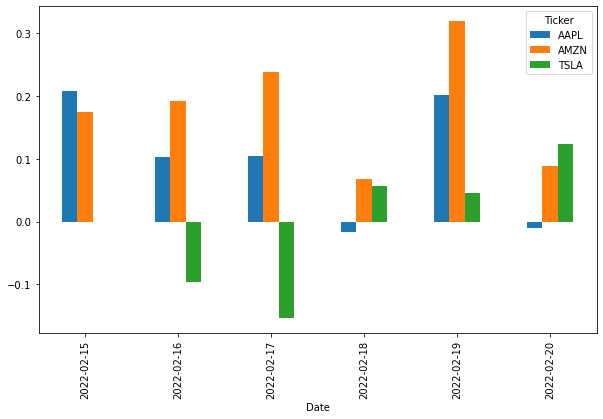

In [11]:
# Plot a bar chart with pandas
mean_c.plot.bar(figsize=(10,6))

In [12]:
# Count the number of headlines in scored_news (store as integer)
num_news_before = news['Headline'].count()
# Drop duplicates based on ticker and headline
news_clean = news.drop_duplicates(['Ticker','Headline'])
# Count number of headlines after dropping duplicates
num_news_after = news_clean['Headline'].count()
# Print before and after numbers to get an idea of how we did 
f"Before we had {num_news_before} headlines, now we have {num_news_after}"

'Before we had 300 headlines, now we have 296'

In [13]:
news_clean.head(5)

,Ticker,Date,Time,Headline,neg,neu,pos,compound
0,AAPL,2022-02-20,08:30PM,Futures Slash Losses On Possible Biden-Putin S...,0.279,0.581,0.140,-0.3387
1,AAPL,2022-02-20,01:32PM,Apple Might Have a Wage War on Its Hands,0.358,0.642,0.000,-0.5994
2,AAPL,2022-02-20,11:35AM,Can Apple Succeed Where Amazon Has Struggled?,0.212,0.354,0.434,0.3612
3,AAPL,2022-02-20,09:06AM,Apple May Have a Wage War On Its Hands,0.358,0.642,0.000,-0.5994
4,AAPL,2022-02-20,08:39AM,Dow Jones Futures: Markets Await Putin's Ukrai...,0.000,0.759,0.241,0.4226


In [14]:
aapl_day = news_clean[news_clean['Ticker']=='AAPL']
aapl_day = aapl_day.set_index('Ticker')
print(aapl_day.head(5))

              Date     Time  \
Ticker                        
AAPL    2022-02-20  08:30PM   
AAPL    2022-02-20  01:32PM   
AAPL    2022-02-20  11:35AM   
AAPL    2022-02-20  09:06AM   
AAPL    2022-02-20  08:39AM   

                                                 Headline    neg    neu  \
Ticker                                                                    
AAPL    Futures Slash Losses On Possible Biden-Putin S...  0.279  0.581   
AAPL             Apple Might Have a Wage War on Its Hands  0.358  0.642   
AAPL        Can Apple Succeed Where Amazon Has Struggled?  0.212  0.354   
AAPL               Apple May Have a Wage War On Its Hands  0.358  0.642   
AAPL    Dow Jones Futures: Markets Await Putin's Ukrai...  0.000  0.759   

          pos  compound  
Ticker                   
AAPL    0.140   -0.3387  
AAPL    0.000   -0.5994  
AAPL    0.434    0.3612  
AAPL    0.000   -0.5994  
AAPL    0.241    0.4226  


/var/folders/d8/_jrpdn5s1x57cvk6wx8v7kyw0000gn/T/ipykernel_2065/2726302603.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  plot_day = aapl_day.drop(['compound','Headline','Date','Time'],1)


Text(0, 0.5, 'scores')

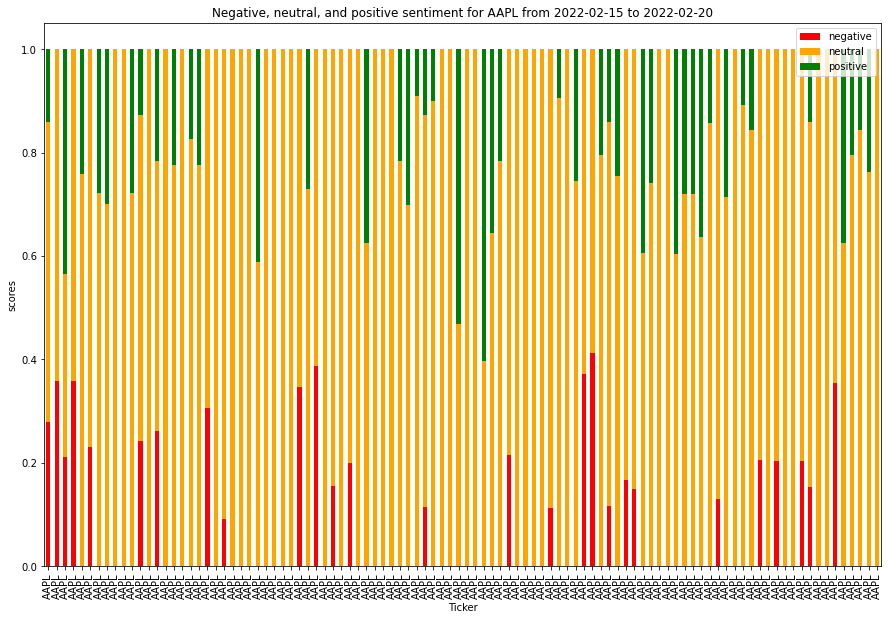

In [15]:
TITLE = "Negative, neutral, and positive sentiment for AAPL from 2022-02-15 to 2022-02-20"
COLORS = ["red","orange", "green"]
# Drop the columns that aren't useful for the plot
plot_day = aapl_day.drop(['compound','Headline','Date','Time'],1)
# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative','neutral','positive']
# Plot a stacked bar chart
plot_day.plot.bar(stacked = True,figsize=(15,10),title=TITLE,color=COLORS)
plt.ylabel('scores')

/var/folders/d8/_jrpdn5s1x57cvk6wx8v7kyw0000gn/T/ipykernel_2065/3250943567.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  plot_day = tsla_day.drop(['compound','Headline','Date','Time'],1)


Text(0, 0.5, 'scores')

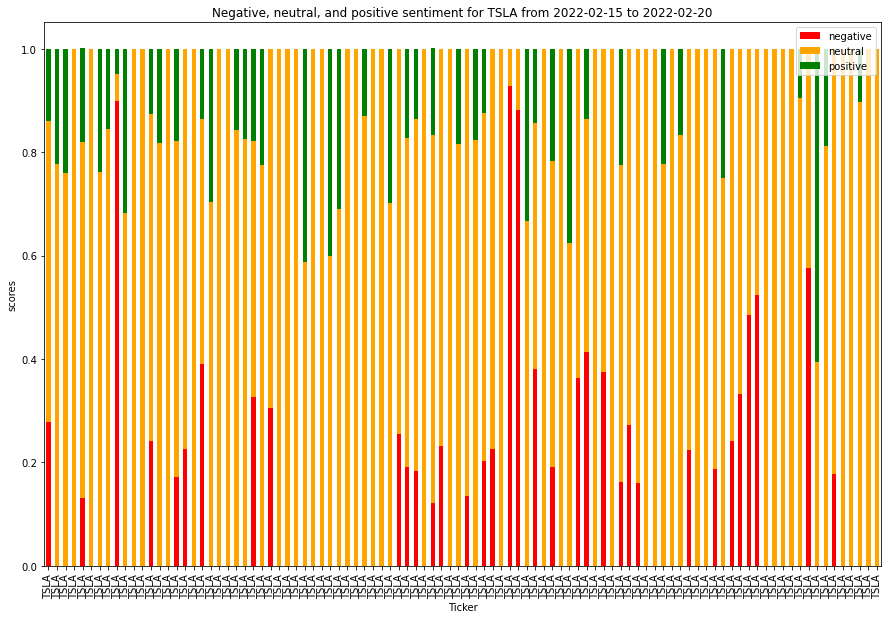

In [16]:
tsla_day = news_clean[news_clean['Ticker']=='TSLA']
tsla_day = tsla_day.set_index('Ticker')
TITLE = "Negative, neutral, and positive sentiment for TSLA from 2022-02-15 to 2022-02-20"
COLORS = ["red","orange", "green"]
# Drop the columns that aren't useful for the plot
plot_day = tsla_day.drop(['compound','Headline','Date','Time'],1)
# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative','neutral','positive']
# Plot a stacked bar chart
plot_day.plot.bar(stacked = True,figsize=(15,10),title=TITLE,color=COLORS)
plt.ylabel('scores')

/var/folders/d8/_jrpdn5s1x57cvk6wx8v7kyw0000gn/T/ipykernel_2065/3602080827.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  plot_day = amzn_day.drop(['compound','Headline','Date','Time'],1)


Text(0, 0.5, 'scores')

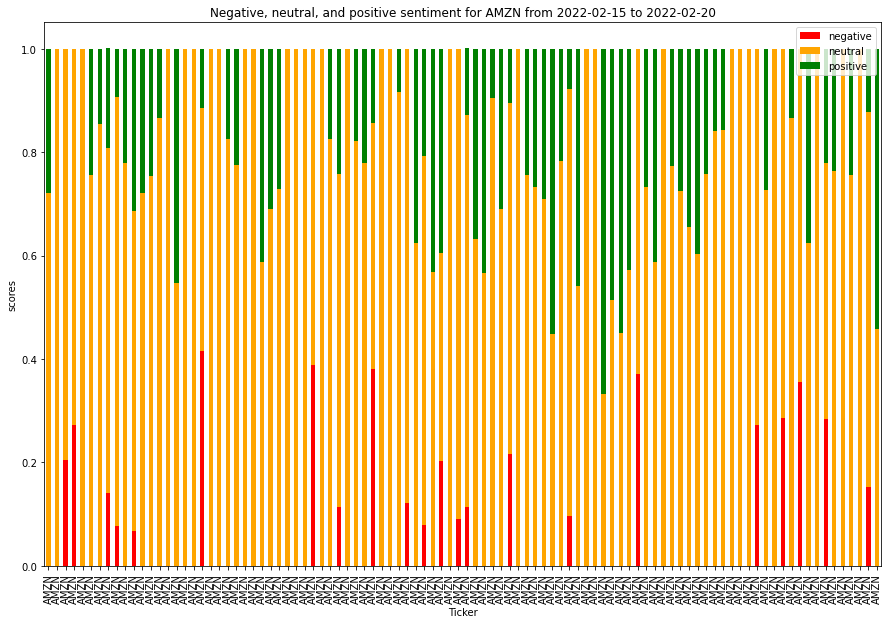

In [17]:
amzn_day = news_clean[news_clean['Ticker']=='AMZN']
amzn_day = amzn_day.set_index('Ticker')
TITLE = "Negative, neutral, and positive sentiment for AMZN from 2022-02-15 to 2022-02-20"
COLORS = ["red","orange", "green"]
# Drop the columns that aren't useful for the plot
plot_day = amzn_day.drop(['compound','Headline','Date','Time'],1)
# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative','neutral','positive']
# Plot a stacked bar chart
plot_day.plot.bar(stacked = True,figsize=(15,10),title=TITLE,color=COLORS)
plt.ylabel('scores')

In [18]:
# Set the index to ticker and date
single_day = news_clean.set_index(['Ticker','Date'])
print(single_day)

                      Time                                           Headline  \
Ticker Date                                                                     
AAPL   2022-02-20  08:30PM  Futures Slash Losses On Possible Biden-Putin S...   
       2022-02-20  01:32PM           Apple Might Have a Wage War on Its Hands   
       2022-02-20  11:35AM      Can Apple Succeed Where Amazon Has Struggled?   
       2022-02-20  09:06AM             Apple May Have a Wage War On Its Hands   
       2022-02-20  08:39AM  Dow Jones Futures: Markets Await Putin's Ukrai...   
...                    ...                                                ...   
AMZN   2022-02-15  04:43PM  ViacomCBS rebrands to Paramount as streaming s...   
       2022-02-15  04:31PM  Inflation: Tech companies may be best able to ...   
       2022-02-15  04:31PM       Biggest Companies in the World by Market Cap   
       2022-02-15  02:33PM  As Amazon, JPMorgan drop mask mandates, Raleig...   
       2022-02-15  02:00PM  

In [19]:
type(single_day.index)

pandas.core.indexes.multi.MultiIndex

In [20]:
# analyze sentiment for AAPL
single_day = single_day.xs('AAPL','Date' == '2022-02-20') 
print(single_day)

               Time                                           Headline    neg  \
Date                                                                            
2022-02-20  08:30PM  Futures Slash Losses On Possible Biden-Putin S...  0.279   
2022-02-20  01:32PM           Apple Might Have a Wage War on Its Hands  0.358   
2022-02-20  11:35AM      Can Apple Succeed Where Amazon Has Struggled?  0.212   
2022-02-20  09:06AM             Apple May Have a Wage War On Its Hands  0.358   
2022-02-20  08:39AM  Dow Jones Futures: Markets Await Putin's Ukrai...  0.000   
...             ...                                                ...    ...   
2022-02-16  07:35AM         Is Alphabet the Best FAANG Stock for 2022?  0.000   
2022-02-16  07:19AM  Top 5 Nasdaq Composite Stocks Amid Index's YTD...  0.000   
2022-02-15  05:02PM  Apple is Berkshires largest stock holding, but...  0.000   
2022-02-15  04:57PM  Apple, Amazon, Microsoft or Tesla: Which Will ...  0.000   
2022-02-15  04:43PM  ViacomC

In [21]:
# Convert the datetime string to just the time
single_day['Time'] = pd.to_datetime(single_day['Time']).dt.time
# Set the index to time and sort by it
single_day = single_day.set_index('Time')
# Sort it
single_day = single_day.sort_index()
print(single_day)

                                                   Headline    neg    neu  \
Time                                                                        
00:55:00  The 10 Stocks That Stephen Perkins Toronado Pa...  0.000  1.000   
04:00:00         How predictive text took over the internet  0.000  1.000   
04:34:00  The Zacks Analyst Blog Highlights: Apple Inc.,...  0.000  1.000   
04:43:00  The Zacks Analyst Blog Highlights: Apple Inc.,...  0.000  0.905   
05:00:00  Apple Shareholders Are Urged to Vote Against C...  0.113  0.887   
...                                                     ...    ...    ...   
19:37:00  Intel Sees Sales Picking Up in Coming Years as...  0.000  1.000   
20:17:00  Intel CEO Is Tired of Wall Street Doubting His...  0.371  0.629   
20:30:00  Futures Slash Losses On Possible Biden-Putin S...  0.279  0.581   
21:00:00  Google to Limit Personal Information Shared on...  0.000  0.745   
23:50:00  Apple Enlists Korean Director Park Chan-wook t...  0.156  0.844   

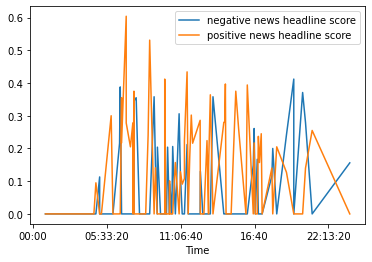

In [22]:
single_day['neg'].plot(label='negative news headline score')
single_day['pos'].plot(label='positive news headline score')
plt.legend()
plt.show()